In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io, transform
import pickle, bz2
%matplotlib inline

# Experiment with convolutions using them directly

See

- [Up-sampling with Transposed Convolution](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0)
- [Types of convolution](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)
- [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)
- [Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)


**Convolution 2D*
![](Images/convolution2d.gif)   

**Convolution 2D Transposed**
![](Images/convolution2d-transposed.gif)

### 2d convolution

load an image and one filter

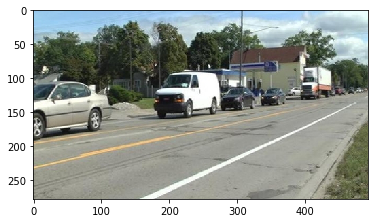

In [2]:
img = io.imread("Images/cars-driving.jpg")
plt.imshow(img)

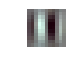

In [3]:
alex_c12 = pickle.load(bz2.BZ2File("data/alexnet_conv1_conv2.pklz", "r"), encoding="bytes")
filter_number = 90
akernel = alex_c12[b"conv1"][0][:,:,:,filter_number]
abias   = alex_c12[b"conv1"][1][filter_number]
plt.figure(figsize=(.7,.7))
plt.imshow((akernel-np.min(akernel))/(np.max(akernel)-np.min(akernel)))
plt.axis("off");

observe how we do one convolution, setting the initializers with the filter we just loaded

In [4]:
tf.reset_default_graph()
tX    = tf.placeholder(tf.float32, shape=[None] + list(img.shape), name="X")
layer = tf.layers.conv2d(tX, filters=1, kernel_size=[11,11], 
                         kernel_initializer=tf.initializers.constant(akernel),
                         bias_initializer=tf.initializers.constant(abias), 
                         activation="linear")
init  = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    output_img = sess.run(layer, feed_dict={tX: np.r_[[img]]})

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.


In [5]:
print(output_img.shape)

(1, 268, 483, 1)


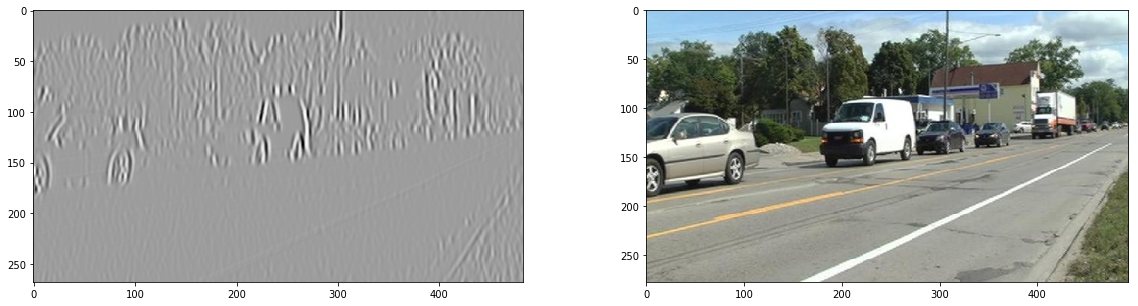

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(output_img[0,:,:,0], cmap=plt.cm.Greys_r)
plt.subplot(122)
plt.imshow(img)

observe how the layer internally creates TensorFlow variables

In [6]:
print("TF variables declared globally:")
print("\n".join([str(i) for i in layer.graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)]))

TF variables declared globally:
<tf.Variable 'conv2d/kernel:0' shape=(11, 11, 3, 1) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(1,) dtype=float32_ref>


### 1d convolution

observe how {`tf.layers.conv1d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv1d) internally creates two variables

In [7]:
tf.reset_default_graph()
tX    = tf.placeholder(tf.float32, shape=[None, 6, 1], name="X")
layer = tf.layers.conv1d(tX, filters=2, kernel_size=3, 
                         bias_initializer=tf.initializers.random_uniform([2]), 
                         activation="tanh")

init  = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.conv1d instead.


In [8]:
print("TF variables declared globally:")
print("\n".join([str(i) for i in layer.graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)]))

TF variables declared globally:
<tf.Variable 'conv1d/kernel:0' shape=(3, 1, 2) dtype=float32_ref>
<tf.Variable 'conv1d/bias:0' shape=(2,) dtype=float32_ref>


In [9]:
tkernel, tbias = layer.graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

In [10]:
tkernel.shape, tbias.shape

(TensorShape([Dimension(3), Dimension(1), Dimension(2)]),
 TensorShape([Dimension(2)]))

observe how TF initializes the kernel and bias differently each time a session is run

In [12]:
for _ in range(2):
    with tf.Session() as sess:
        sess.run(init)
        kernel, bias = sess.run([tkernel, tbias])
        print("kernel shape", kernel.shape, "bias shape", bias.shape)
        print("\n--", kernel)
        print("\n--", bias)
        print("\n")

kernel shape (3, 1, 2) bias shape (2,)

-- [[[-0.35561088 -0.5086522 ]]

 [[ 0.71262085 -0.6954972 ]]

 [[ 0.65461445  0.6750238 ]]]

-- [1.451411  1.2743202]


kernel shape (3, 1, 2) bias shape (2,)

-- [[[ 0.798476    0.09022021]]

 [[ 0.57554555 -0.6481694 ]]

 [[ 0.00328755  0.52328193]]]

-- [1.9572406 1.7188766]




### evaluating TensorFlow's convolution

first create a random input

In [13]:
size=7
X = np.random.randint(3, size=[size]+tX.shape.as_list()[1:])
X.shape

(7, 6, 1)

In [14]:
X.T

array([[[0, 1, 0, 1, 0, 1, 2],
        [1, 1, 2, 1, 1, 0, 1],
        [2, 0, 2, 0, 1, 1, 0],
        [2, 0, 2, 1, 0, 1, 2],
        [2, 1, 2, 2, 1, 2, 2],
        [0, 1, 0, 1, 0, 1, 1]]])

then feed it to the computational graph

In [18]:
with tf.Session() as sess:
    sess.run(init)
    output, kernel, bias = sess.run([layer, tkernel, tbias], feed_dict={tX: X})

In [19]:
print(X.shape)
print(kernel.shape)
print(bias.shape)
print(output.shape)

(7, 6, 1)
(3, 1, 2)
(2,)
(7, 4, 2)


In [20]:
print(output)

[[[ 0.77885044  0.04511712]
  [ 0.8737725  -0.43484485]
  [ 0.9310353  -0.23737873]
  [ 0.9793989   0.55839795]]

 [[ 0.96230936  0.8149205 ]
  [ 0.963109    0.95416814]
  [ 0.87676716  0.8385479 ]
  [ 0.8742158   0.44736105]]

 [[ 0.77451533 -0.5978002 ]
  [ 0.9310353  -0.23737873]
  [ 0.9310353  -0.23737873]
  [ 0.9793989   0.55839795]]

 [[ 0.96230936  0.8149205 ]
  [ 0.93272024  0.89372236]
  [ 0.77885044  0.04511712]
  [ 0.9298199  -0.02959888]]

 [[ 0.8742158   0.44736105]
  [ 0.96230936  0.8149205 ]
  [ 0.93272024  0.89372236]
  [ 0.9300736   0.7247812 ]]

 [[ 0.93272024  0.89372236]
  [ 0.8742158   0.44736105]
  [ 0.87633234  0.26270258]
  [ 0.9298199  -0.02959888]]

 [[ 0.9798397   0.877632  ]
  [ 0.8788436   0.7632164 ]
  [ 0.77451533 -0.5978002 ]
  [ 0.96217036  0.19184688]]]


### doing the convolution by hand

the loop is for each convolution step

In [21]:
c = np.r_[[np.tanh(X[:,i:i+kernel.shape[0],0].dot(kernel[:,0,:])+bias) \
            for i in range(X.shape[1]-kernel.shape[0]+1)]].swapaxes(0,1).reshape(output.shape)
c

array([[[ 0.77885047,  0.04511713],
        [ 0.87377253, -0.43484484],
        [ 0.93103528, -0.23737875],
        [ 0.97939892,  0.55839794]],

       [[ 0.96230935,  0.81492053],
        [ 0.96310904,  0.95416819],
        [ 0.87676722,  0.8385478 ],
        [ 0.8742158 ,  0.44736103]],

       [[ 0.77451534, -0.59780028],
        [ 0.93103528, -0.23737875],
        [ 0.93103528, -0.23737875],
        [ 0.97939892,  0.55839794]],

       [[ 0.96230935,  0.81492053],
        [ 0.93272022,  0.89372237],
        [ 0.77885047,  0.04511713],
        [ 0.92981994, -0.02959883]],

       [[ 0.8742158 ,  0.44736103],
        [ 0.96230935,  0.81492053],
        [ 0.93272022,  0.89372237],
        [ 0.93007374,  0.72478119]],

       [[ 0.93272022,  0.89372237],
        [ 0.8742158 ,  0.44736103],
        [ 0.87633235,  0.26270257],
        [ 0.92981994, -0.02959883]],

       [[ 0.97983975,  0.87763206],
        [ 0.87884362,  0.76321637],
        [ 0.77451534, -0.59780028],
        [ 0.9621

In [22]:
np.allclose(output, c)

True

### using a convolution matrix

the filter is transformed into a matrix so that when doing matrix multiplication with the original input, the result contains the elements obtained through a sequential convolution.

In [23]:
def get_conv_matrix(input_shape, kernel):
     return np.r_[[[0]*i+list(kernel)+[0]*(input_shape[1]-kernel.shape[0]-i) \
                   for i in range(input_shape[1]-kernel.shape[0]+1)]]

convolution matrix for the first filter

In [24]:
cm = get_conv_matrix(X.shape,kernel[:,0,1])
print(cm.shape)
cm.T

(4, 6)


array([[ 0.22386134,  0.        ,  0.        ,  0.        ],
       [-0.73486495,  0.22386134,  0.        ,  0.        ],
       [-0.43624836, -0.73486495,  0.22386134,  0.        ],
       [ 0.        , -0.43624836, -0.73486495,  0.22386134],
       [ 0.        ,  0.        , -0.43624836, -0.73486495],
       [ 0.        ,  0.        ,  0.        , -0.43624836]])

In [25]:
X.shape

(7, 6, 1)

In [26]:
np.tanh(X[:,:,0].dot(cm.T)+bias[0])

array([[ 0.0624197 , -0.42066741, -0.22093733,  0.57022447],
       [ 0.82066769,  0.95569693,  0.84362449,  0.46113299],
       [-0.58653277, -0.22093733, -0.22093733,  0.57022447],
       [ 0.82066769,  0.8971612 ,  0.0624197 , -0.01225368],
       [ 0.46113299,  0.82066769,  0.8971612 ,  0.73291548],
       [ 0.8971612 ,  0.46113299,  0.27878324, -0.01225368],
       [ 0.88155896,  0.77036593, -0.58653277,  0.20850419]])

and for all the filters together

In [27]:
c = np.r_[[np.tanh(X[:,:,0].dot(get_conv_matrix(X.shape, kernel[:,0,i]).T)+bias[i]).T \
          for i in range(kernel.shape[-1])]].swapaxes(2,0).reshape(output.shape)
c

array([[[ 0.77885047,  0.04511713],
        [ 0.87377253, -0.43484484],
        [ 0.93103528, -0.23737875],
        [ 0.97939892,  0.55839794]],

       [[ 0.96230935,  0.81492053],
        [ 0.96310904,  0.95416819],
        [ 0.87676722,  0.8385478 ],
        [ 0.8742158 ,  0.44736103]],

       [[ 0.77451534, -0.59780028],
        [ 0.93103528, -0.23737875],
        [ 0.93103528, -0.23737875],
        [ 0.97939892,  0.55839794]],

       [[ 0.96230935,  0.81492053],
        [ 0.93272022,  0.89372237],
        [ 0.77885047,  0.04511713],
        [ 0.92981994, -0.02959883]],

       [[ 0.8742158 ,  0.44736103],
        [ 0.96230935,  0.81492053],
        [ 0.93272022,  0.89372237],
        [ 0.93007374,  0.72478119]],

       [[ 0.93272022,  0.89372237],
        [ 0.8742158 ,  0.44736103],
        [ 0.87633235,  0.26270257],
        [ 0.92981994, -0.02959883]],

       [[ 0.97983975,  0.87763206],
        [ 0.87884362,  0.76321637],
        [ 0.77451534, -0.59780028],
        [ 0.9621

In [28]:
np.allclose(c, output)

True

### transposed convolution

In [29]:
cm = get_conv_matrix(X.shape,kernel[:,0,1])

direct convolution

In [30]:
np.tanh(X[:,:,0].dot(cm.T)+bias[0])

array([[ 0.0624197 , -0.42066741, -0.22093733,  0.57022447],
       [ 0.82066769,  0.95569693,  0.84362449,  0.46113299],
       [-0.58653277, -0.22093733, -0.22093733,  0.57022447],
       [ 0.82066769,  0.8971612 ,  0.0624197 , -0.01225368],
       [ 0.46113299,  0.82066769,  0.8971612 ,  0.73291548],
       [ 0.8971612 ,  0.46113299,  0.27878324, -0.01225368],
       [ 0.88155896,  0.77036593, -0.58653277,  0.20850419]])

In [31]:
output.shape, X.shape, cm.shape

((7, 4, 2), (7, 6, 1), (4, 6))

transposed convolution. It recovers the **shape** of the original input (not the content)

In [32]:
tc = output[:,:,0].dot(cm).reshape(X.shape)
tc.T

array([[[ 0.1743545 ,  0.21542386,  0.17338404,  0.21542386,
          0.19570311,  0.2088    ,  0.21934822],
        [-0.37674601, -0.49156455, -0.36074137, -0.49836742,
         -0.42700668, -0.4897203 , -0.52331074],
        [-0.77345421, -0.93128667, -0.81364344, -0.9308748 ,
         -0.87974262, -0.85315129, -0.89990078],
        [-0.84611747, -0.86875707, -0.87109826, -0.77109684,
         -0.89702177, -0.8172104 , -0.73716551],
        [-1.12588854, -1.02491877, -1.12588854, -1.02306427,
         -1.09037618, -1.06559059, -1.04494632],
        [-0.42726117, -0.3813752 , -0.42726117, -0.4056324 ,
         -0.40574309, -0.4056324 , -0.41974524]]])

In [33]:
X.T

array([[[0, 1, 0, 1, 0, 1, 2],
        [1, 1, 2, 1, 1, 0, 1],
        [2, 0, 2, 0, 1, 1, 0],
        [2, 0, 2, 1, 0, 1, 2],
        [2, 1, 2, 2, 1, 2, 2],
        [0, 1, 0, 1, 0, 1, 1]]])

In [34]:
X.shape, tc.shape

((7, 6, 1), (7, 6, 1))